# Train word2vec CBOW Model with gensim

Subject: Training word embeddings with gensim Word2vec (CBOW algorithm) representing the words' closeness to each other.

Data: Unlabeled "txtlab_Novel150_English" dataset with 150 English novels written over the long nineteenth century

Procedure:
- Tokenizing to sentences with nltk's sentence tokenizer nltk.data.load('tokenizers/punkt/english.pickle') 
- Tokenizing words with nltk.tokenize.word_tokenize
- Training a gensim.models.word2vec.Word2Vec model
- Evaluation with gensim's model.wv.doesnt_match(), model.wv.most_similar(), model.wv.n_similarity(), model.wv.most_similar_cosmul() including the canonical King - Man + Woman -> Queen test (passed)
- Wordclouds for male and female-associated words
- Good results (not reproduced with custom Torch models, cf. other notebooks)

Others:
- working on Colab with Google Drive for loading data

Sources used:
- https://github.com/data-8/literature-connector/blob/gh-pages/13%20-%20The%20Cutting%20Edge/Word%20Embedding.ipynb
- https://www.kaggle.com/code/erenat77/word2vec-with-gensim-word2vec/notebook

In [ ]:
if IN_COLAB := 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = './drive/MyDrive/Colab/'
    import nltk
    nltk.download('punkt')

else:
    BASE_PATH = './'

## Dataset

In [1]:
import pandas as pd

In [2]:
PATH_METADATA_TABLE = BASE_PATH + 'data/novel/txtlab_Novel150_English.csv'
PATH_DIR_NOVELS = BASE_PATH + 'data/novel/txtlab_Novel150_English/'

metadata_tb = pd.read_csv(PATH_METADATA_TABLE)  # contains novel filenames

In [3]:
novels: list[str] = []

for filename in metadata_tb['filename']:
    with open(PATH_DIR_NOVELS+filename, 'r', encoding="utf8") as file_in:
        novel = file_in.read()
    
    # add the whole novel text as single string
    novels.append(novel)

print(f"Read list of {len(novels)} Novels.")

Read list of 150 Novels.


In [4]:
print('Extract from 16th novel:\n\n', novels[15][1003:1105])

Extract from 16th novel:

  evils that flow from an erroneous or imperfect discipline.
My state is not destitute of tranquillity.


## Preprocessing

We currently have our novels as a list of huge strings.
1. First, we split each novel into its sentences. 
2. Then, we split each sentence into its words.

In [5]:
import nltk
import string

### Tokenize Sentences

In [6]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
sentences = [sentence for novel in novels for sentence in sentence_tokenizer.tokenize(novel)]
print(f'Tokenized {len(sentences)} sentences from {len(novels)} novels.')

Tokenized 961915 sentences from 150 novels.


### Tokenize Words

In [8]:
# to remove punctuation
translator = str.maketrans('', '', string.punctuation + '“”')

In [9]:
# Print some example
original_sentence = sentences[111]
print(f'Original sentence  : {original_sentence}')

sentence_without_punctuation = original_sentence.translate(translator)
print(f'Without punctuation: {sentence_without_punctuation}')

tokenized = nltk.tokenize.word_tokenize(sentence_without_punctuation, language='english')
print(f'Tokenized:           {tokenized}')

Original sentence  : “Our delicacies,” said Harley to himself, “are fantastic; they are not in nature!
Without punctuation: Our delicacies said Harley to himself are fantastic they are not in nature
Tokenized:           ['Our', 'delicacies', 'said', 'Harley', 'to', 'himself', 'are', 'fantastic', 'they', 'are', 'not', 'in', 'nature']


In [10]:
sentences_without_punctuation =  [s.translate(translator) for s in sentences]
print(f'Removed punctuation from {len(sentences_without_punctuation)} sentences.')

Removed punctuation from 961915 sentences.


In [11]:
tokenized_sentences = [nltk.tokenize.word_tokenize(s, language='english') for s in sentences_without_punctuation]
print(f'Tokenized {len(tokenized_sentences)} sentences.')

Tokenized 961915 sentences.


In [12]:
words_by_sentence = [s for s in tokenized_sentences if s != []]
print(f'Removed {len(tokenized_sentences) - len(words_by_sentence)} sentences with empty content. {len(words_by_sentence)} tokenized sentences remaining.')

Removed 1704 sentences with empty content. 960211 tokenized sentences remaining.


In [13]:
sentences[100]

'We have mentioned this faithful fellow formerly: Harley’s father had taken him up an orphan, and saved him from being cast on the parish; and he had ever since remained in the service of him and of his son.'

## gensim word2vec Model

In [14]:
from gensim.models import word2vec

In [15]:
model = word2vec.Word2Vec(words_by_sentence,
                          workers=4,  # Number of parallel threads
                          vector_size=200,  # dimensionality of the word vectors.
                          window=5,  # max. distance between the current and predicted word within a sentence.
                          min_count=5,  #ignores all words with total frequency lower than this.
                          sample=1e-3,  # (0.001) Downsample setting for frequent words
                          alpha=0.025,  # initial learning rate
                          epochs=5,  # num of iterations (epochs) over the corpus. 
                          sg=0,  # CBOW (default) - 1 would be skip-gram
                         )

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "200features_5window_5epochs"
print(f"Saving the model to {model_name}. Load later using Word2Vec.load()")
model.save(model_name)

Saving the model to 200features_5window_5epochs. Load later using Word2Vec.load()


## Evaluation

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [32]:
# Few tests: This will print the odd word among them 
model.wv.doesnt_match("man woman king queen princess dog".split())

'dog'

In [33]:
model.wv.doesnt_match("europe africa USA turkey".split())

'turkey'

In [34]:
model.wv.most_similar("best")

[('worst', 0.5842715501785278),
 ('better', 0.48739558458328247),
 ('good', 0.4842498004436493),
 ('wisest', 0.468395859003067),
 ('finest', 0.4528207778930664),
 ('greatest', 0.4528018832206726),
 ('duty', 0.4423225522041321),
 ('kindest', 0.43324390053749084),
 ('highest', 0.408470094203949),
 ('well', 0.4010760486125946)]

In [35]:
model.wv.most_similar("best")

[('worst', 0.5842715501785278),
 ('better', 0.48739558458328247),
 ('good', 0.4842498004436493),
 ('wisest', 0.468395859003067),
 ('finest', 0.4528207778930664),
 ('greatest', 0.4528018832206726),
 ('duty', 0.4423225522041321),
 ('kindest', 0.43324390053749084),
 ('highest', 0.408470094203949),
 ('well', 0.4010760486125946)]

In [36]:
model.wv.most_similar_cosmul(positive=['man', 'woman'], negative=['princess'])

[('fellow', 1.1079950332641602),
 ('gentleman', 1.0495387315750122),
 ('mans', 1.040831208229065),
 ('chap', 0.9985843896865845),
 ('person', 0.9883623719215393),
 ('creature', 0.9848945140838623),
 ('girl', 0.9779794216156006),
 ('lady', 0.9734005331993103),
 ('wretch', 0.9688345789909363),
 ('lad', 0.9403160810470581)]

In [37]:
model.wv.most_similar('sense','sensibility')

[('doing', 0.2848317325115204),
 ('Gallows', 0.2792321741580963),
 ('Calais', 0.2775776982307434),
 ('City', 0.27432364225387573),
 ('jail', 0.26313167810440063),
 ('squad', 0.26233378052711487),
 ('done', 0.2577081322669983),
 ('cab', 0.257174015045166),
 ('Sabe', 0.2545291483402252),
 ('Road', 0.254273921251297)]

In [38]:
# Find cosine distance between two clusters of word vectors
# Each cluster is measured as the mean of its words
model.wv.n_similarity(['sense','sensibility'],['whale','harpoon'])

0.11226824

In [39]:
# Finds mean vector of words in list
# and identifies the word further from that mean
model.wv.doesnt_match(['pride','prejudice', 'harpoon'])

'harpoon'

In [40]:
# The canonic word2vec exercise: King - Man + Woman -> Queen
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6705252528190613),
 ('princess', 0.6071111559867859),
 ('saint', 0.590050458908081),
 ('prince', 0.580885648727417),
 ('Emperor', 0.5786550641059875),
 ('Order', 0.5779697895050049),
 ('Princess', 0.5741350650787354),
 ('Virgin', 0.5628634691238403),
 ('priest', 0.5500859022140503),
 ('princes', 0.544127881526947)]

In [41]:
model.wv.most_similar(positive=['she','her','hers','herself'], 
                      negative=['he','him','his','himself'])

[('girlish', 0.4012824296951294),
 ('beautiful', 0.3984808325767517),
 ('lovely', 0.39280349016189575),
 ('maiden', 0.3893471360206604),
 ('husbands', 0.3757399618625641),
 ('Mary', 0.3743492066860199),
 ('sweet', 0.36983340978622437),
 ('girlhood', 0.3654516637325287),
 ('grandmothers', 0.35940447449684143),
 ('Aunt', 0.3527800142765045)]

In [42]:
model.wv.most_similar(positive=['he','him','his','himself'], 
                      negative=['she','her','hers','herself'])


[('horse', 0.37668219208717346),
 ('captain', 0.36930039525032043),
 ('Bill', 0.36846551299095154),
 ('club', 0.3486751914024353),
 ('gun', 0.3441280722618103),
 ('pipe', 0.3315260410308838),
 ('Peoples', 0.3263849914073944),
 ('Cherokee', 0.3239407241344452),
 ('realestate', 0.323864221572876),
 ('Buck', 0.3220592439174652)]

In [ ]:
# get words strongly associated with female gender
her_tokens = [token for token,weight in model.wv.most_similar
              (positive=['he','him','his','himself'],
               negative=['she','her','hers','herself'], 
               topn=50)]
her_tokens[:10]

In [44]:
# wordcloud for male-gender-associated words
male_associated: list[tuple[str, float]] = model.wv.most_similar(positive=['he','him','his','himself'], 
                                                                 negative=['she','her','hers','herself'],
                                                                 topn=50)
male_associated_int: list[tuple[str, float]] = [(w, round(m*100)) for (w, m) in male_associated]
male_associated_words_multiplied: list[list[str]] = [[w] * i for (w, i) in male_associated_int]
male_words_flat: list[str] = [w for words in male_associated_words_multiplied for w in words]
male_words: str = ' '.join(male_words_flat)

# wordcloud for female-gender-associated words
female_associated: list[tuple[str, float]] = model.wv.most_similar(positive=['she','her','hers','herself'], 
                                                                 negative=['he','him','his','himself'],
                                                                 topn=50)
female_associated_int: list[tuple[str, float]] = [(w, round(m*100)) for (w, m) in female_associated]
female_associated_words_multiplied: list[list[str]] = [[w] * i for (w, i) in female_associated_int]
female_words_flat: list[str] = [w for words in female_associated_words_multiplied for w in words]
female_words: str = ' '.join(female_words_flat)

word_cloud_male = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        ).generate(male_words)

word_cloud_female = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        ).generate(female_words)


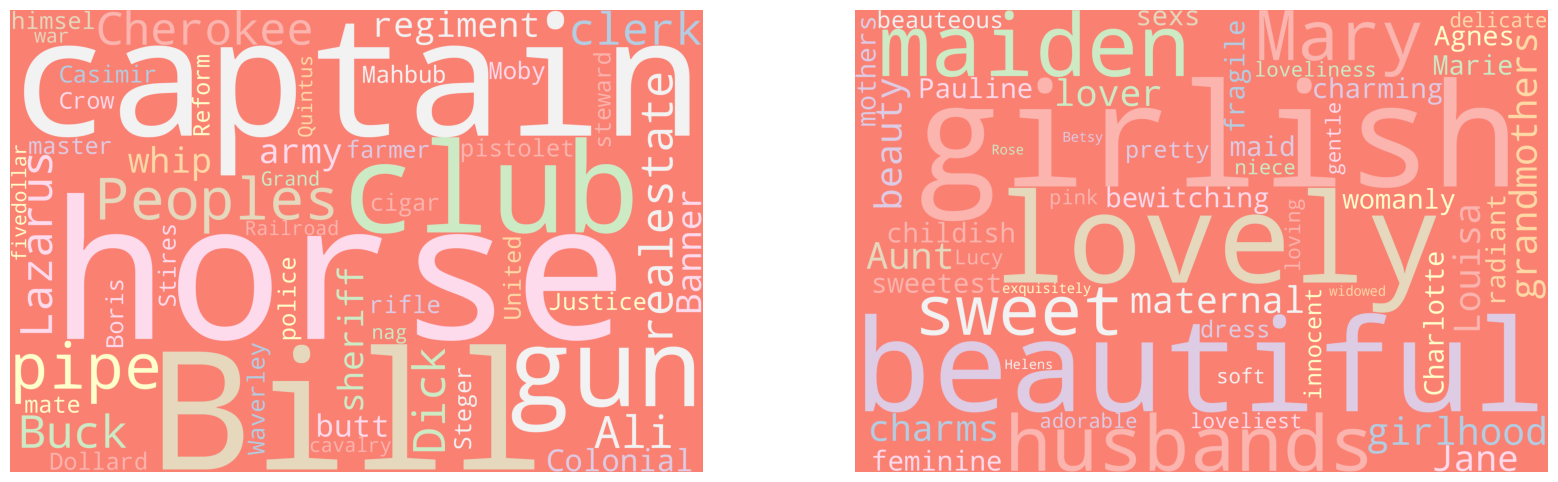

In [47]:
_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.imshow(word_cloud_male)
ax2.imshow(word_cloud_female)
ax1.axis("off")
ax2.axis("off")
plt.show()